In [2]:
import matplotlib.pyplot as plt

In [3]:
import json
import zipfile  
import pandas as pd

In [91]:
import plotly.express as px

In [4]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [6]:
from pyspark.sql import SparkSession

In [79]:
metadata= {"@type": "dcat:Dataset", 
           "accessLevel": "public", 
           "accrualPeriodicity": "R/P1D", 
           "bureauCode": ["581:00"], 
           "contactPoint": {"@type": "vcard:Contact", "fn": "devops@cfpb.gov", "hasEmail": "mailto:devops@cfpb.gov"}, 
           "describedBy": "https://cfpb.github.io/api/ccdb/api.html", 
           "description": "The Consumer Complaint Database is a collection of complaints about consumer financial products and services that we sent to companies for response. Complaints are published after the company responds, confirming a commercial relationship with the consumer, or after 15 days, whichever comes first. Complaints referred to other regulators, such as complaints about depository institutions with less than $10 billion in assets, are not published in the Consumer Complaint Database. The database generally updates daily.", "distribution": [{"@type": "dcat:Distribution", "downloadURL": "https://files.consumerfinance.gov/ccdb/complaints.csv.zip", "mediaType": "text/csv"}, {"@type": "dcat:Distribution", "downloadURL": "https://files.consumerfinance.gov/ccdb/complaints.json.zip", "mediaType": "application/json"}, {"@type": "dcat:Distribution", "accessURL": "https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/", "format": "API"}], "identifier": "CCDB", "keyword": ["consumer", "finance", "complaint", "bank account", "bank service", "credit card", "credit report", "debt collection", "money transfer", "mortgage", "student loan", "loan"], "landingPage": "https://www.consumerfinance.gov/data-research/consumer-complaints/", "modified": "2020-06-29", "programCode": ["000:000"], "publisher": {"@type": "org:Organization", "name": "Consumer Financial Protection Bureau"}, "spatial": "United States", "title": "Consumer Complaint Database"}

In [80]:
metadata

{'@type': 'dcat:Dataset',
 'accessLevel': 'public',
 'accrualPeriodicity': 'R/P1D',
 'bureauCode': ['581:00'],
 'contactPoint': {'@type': 'vcard:Contact',
  'fn': 'devops@cfpb.gov',
  'hasEmail': 'mailto:devops@cfpb.gov'},
 'describedBy': 'https://cfpb.github.io/api/ccdb/api.html',
 'description': 'The Consumer Complaint Database is a collection of complaints about consumer financial products and services that we sent to companies for response. Complaints are published after the company responds, confirming a commercial relationship with the consumer, or after 15 days, whichever comes first. Complaints referred to other regulators, such as complaints about depository institutions with less than $10 billion in assets, are not published in the Consumer Complaint Database. The database generally updates daily.',
 'distribution': [{'@type': 'dcat:Distribution',
   'downloadURL': 'https://files.consumerfinance.gov/ccdb/complaints.csv.zip',
   'mediaType': 'text/csv'},
  {'@type': 'dcat:Dist

In [12]:
spark = SparkSession.builder.master("local[4]") \
                    .appName('complaints_analysis') \
                    .config("spark.driver.memory", "15g") \
                    .getOrCreate()

22/12/07 07:19:17 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [21]:
# data = None  
# with zipfile.ZipFile("data/complaints.json.zip", "r") as z:
#     for filename in z.namelist():  
#         print(filename)
#         with z.open(filename) as f:  
#             data = f.read()
#             complaints_df = spark.read.json('data/' + filename, multiLine=True) #json.loads(data.decode("utf-8"))

https://files.consumerfinance.gov/ccdb/complaints.json.zip

In [17]:
complaints_df = spark.read.json('data/complaints.json.gz', multiLine=True)

In [23]:
complaints_df.show()

+--------------------+-----------------------+--------------------+------------+-----------------------+-------------------------+-----------------+-------------+--------------------+--------------------+--------------------+-----+--------------------+----------------+-------------+-------------+------+--------+
|             company|company_public_response|    company_response|complaint_id|complaint_what_happened|consumer_consent_provided|consumer_disputed|date_received|date_sent_to_company|               issue|             product|state|           sub_issue|     sub_product|submitted_via|         tags|timely|zip_code|
+--------------------+-----------------------+--------------------+------------+-----------------------+-------------------------+-----------------+-------------+--------------------+--------------------+--------------------+-----+--------------------+----------------+-------------+-------------+------+--------+
|Experian Informat...|   Company has respo...|Closed with 

In [22]:
print(f'The number of complaints in dataset is {complaints_df.count()}')
print(f'The number of features in dataset is {len(complaints_df.columns)}')

The number of complaints in dataset is 3127776
The number of features in dataset is 18


In [65]:
print(f"The number of unique complaints in dataset is {complaints_df.select(countDistinct('complaint_id')).collect()[0][0]}")

The number of unique complaints in dataset is 3127776


There are no duplicate complaints in the dataset

In [24]:
complaints_df.printSchema()

root
 |-- company: string (nullable = true)
 |-- company_public_response: string (nullable = true)
 |-- company_response: string (nullable = true)
 |-- complaint_id: string (nullable = true)
 |-- complaint_what_happened: string (nullable = true)
 |-- consumer_consent_provided: string (nullable = true)
 |-- consumer_disputed: string (nullable = true)
 |-- date_received: string (nullable = true)
 |-- date_sent_to_company: string (nullable = true)
 |-- issue: string (nullable = true)
 |-- product: string (nullable = true)
 |-- state: string (nullable = true)
 |-- sub_issue: string (nullable = true)
 |-- sub_product: string (nullable = true)
 |-- submitted_via: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- timely: string (nullable = true)
 |-- zip_code: string (nullable = true)



Dataset has two date columns but they are in string format. I will convert them to datetime data type

In [25]:
from pyspark.sql.functions import col, to_date, min, max, countDistinct, count, desc, year

In [26]:
complaints_df = complaints_df.withColumn("date_received", to_date("date_received"))
complaints_df = complaints_df.withColumn("date_sent_to_company", to_date("date_sent_to_company"))
complaints_df.show()

+--------------------+-----------------------+--------------------+------------+-----------------------+-------------------------+-----------------+-------------+--------------------+--------------------+--------------------+-----+--------------------+----------------+-------------+-------------+------+--------+
|             company|company_public_response|    company_response|complaint_id|complaint_what_happened|consumer_consent_provided|consumer_disputed|date_received|date_sent_to_company|               issue|             product|state|           sub_issue|     sub_product|submitted_via|         tags|timely|zip_code|
+--------------------+-----------------------+--------------------+------------+-----------------------+-------------------------+-----------------+-------------+--------------------+--------------------+--------------------+-----+--------------------+----------------+-------------+-------------+------+--------+
|Experian Informat...|   Company has respo...|Closed with 

In [27]:
complaints_df.printSchema()

root
 |-- company: string (nullable = true)
 |-- company_public_response: string (nullable = true)
 |-- company_response: string (nullable = true)
 |-- complaint_id: string (nullable = true)
 |-- complaint_what_happened: string (nullable = true)
 |-- consumer_consent_provided: string (nullable = true)
 |-- consumer_disputed: string (nullable = true)
 |-- date_received: date (nullable = true)
 |-- date_sent_to_company: date (nullable = true)
 |-- issue: string (nullable = true)
 |-- product: string (nullable = true)
 |-- state: string (nullable = true)
 |-- sub_issue: string (nullable = true)
 |-- sub_product: string (nullable = true)
 |-- submitted_via: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- timely: string (nullable = true)
 |-- zip_code: string (nullable = true)



In [28]:
min_date, max_date = complaints_df.select(min("date_received"), max("date_received")).first()
print(f'The range of the complaints received date is {min_date.strftime("%m/%d/%Y")} and {max_date.strftime("%m/%d/%Y")}')

The range of the complaints received date is 12/01/2011 and 12/05/2022


In [29]:
print(f'The total number of companies in the dataset is {complaints_df.select(countDistinct("company")).collect()[0][0]}')

The total number of companies in the dataset is 6581


[Row(count(DISTINCT complaint_id)=3127776)]

In [31]:
ComplaintsCountPerCompany = complaints_df.groupBy("company")\
                                    .agg(count("*").alias("ComplaintsCount"))\
                                    .sort(desc("ComplaintsCount"))
ComplaintsCountPerCompany.show()

+--------------------+---------------+
|             company|ComplaintsCount|
+--------------------+---------------+
|       EQUIFAX, INC.|         538662|
|TRANSUNION INTERM...|         443688|
|Experian Informat...|         415222|
|BANK OF AMERICA, ...|         120194|
|WELLS FARGO & COM...|         101653|
|JPMORGAN CHASE & CO.|          96503|
|      CITIBANK, N.A.|          79735|
|CAPITAL ONE FINAN...|          74032|
| SYNCHRONY FINANCIAL|          40366|
|Navient Solutions...|          37508|
|Ocwen Financial C...|          33247|
|        U.S. BANCORP|          30257|
| NATIONSTAR MORTGAGE|          26881|
|AMERICAN EXPRESS ...|          25578|
|PORTFOLIO RECOVER...|          22299|
|       DISCOVER BANK|          21496|
|       PNC Bank N.A.|          21391|
|ENCORE CAPITAL GR...|          19989|
|TD BANK US HOLDIN...|          19627|
|Bread Financial H...|          19279|
+--------------------+---------------+
only showing top 20 rows



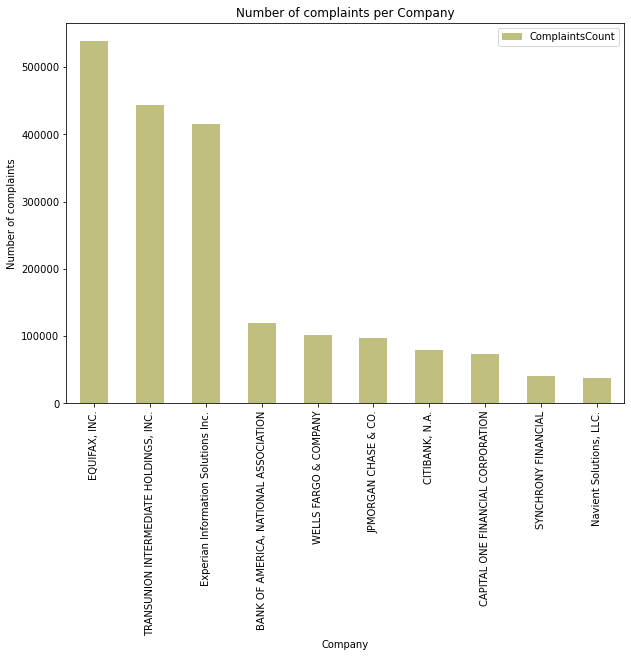

In [33]:
pl = ComplaintsCountPerCompany.toPandas().head(10).plot(kind="bar", 
                            x="company", y="ComplaintsCount", 
                            figsize=(10, 7), alpha=0.5, color="olive")
pl.set_xlabel("Company")
pl.set_ylabel("Number of complaints")
pl.set_title("Number of complaints per Company")
plt.show()

In [34]:
ComplaintsCountPerYear = complaints_df.groupBy(year("date_received").alias("year"))\
                                    .agg(count("*").alias("ComplaintsCount"))\
                                    .sort("year")
ComplaintsCountPerYear.show()

+----+---------------+
|year|ComplaintsCount|
+----+---------------+
|2011|           2536|
|2012|          72373|
|2013|         108217|
|2014|         153034|
|2015|         168466|
|2016|         191457|
|2017|         242931|
|2018|         257252|
|2019|         277324|
|2020|         444329|
|2021|         496019|
|2022|         713838|
+----+---------------+



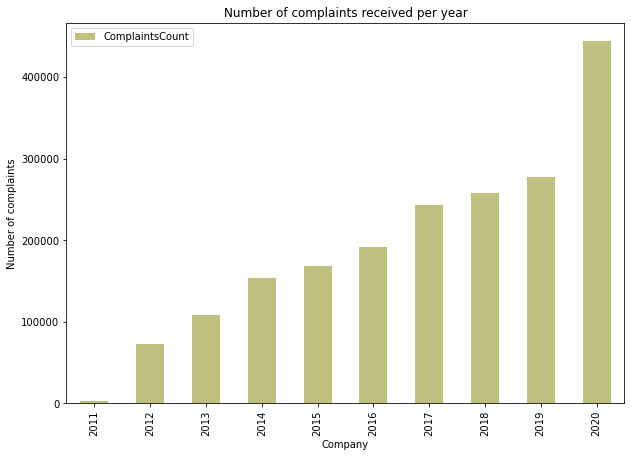

In [35]:
pl = ComplaintsCountPerYear.toPandas().head(10).plot(kind="bar", 
                            x="year", y="ComplaintsCount", 
                            figsize=(10, 7), alpha=0.5, color="olive")
pl.set_xlabel("Company")
pl.set_ylabel("Number of complaints")
pl.set_title("Number of complaints received per year")
plt.show()

In [36]:
ComplaintsCountPerProduct = complaints_df.groupBy("product")\
                                    .agg(count("*").alias("ComplaintsCount"))\
                                    .sort(desc("ComplaintsCount"))
ComplaintsCountPerProduct.show()

+--------------------+---------------+
|             product|ComplaintsCount|
+--------------------+---------------+
|Credit reporting,...|        1452854|
|     Debt collection|         454053|
|            Mortgage|         365651|
|Credit card or pr...|         166567|
|Checking or savin...|         142819|
|    Credit reporting|         140429|
|         Credit card|          89190|
|Bank account or s...|          86206|
|        Student loan|          71721|
|Money transfer, v...|          48122|
|Vehicle loan or l...|          37409|
|       Consumer Loan|          31596|
|Payday loan, titl...|          25367|
|         Payday loan|           5543|
|     Money transfers|           5354|
|        Prepaid card|           3819|
|Other financial s...|           1058|
|    Virtual currency|             18|
+--------------------+---------------+



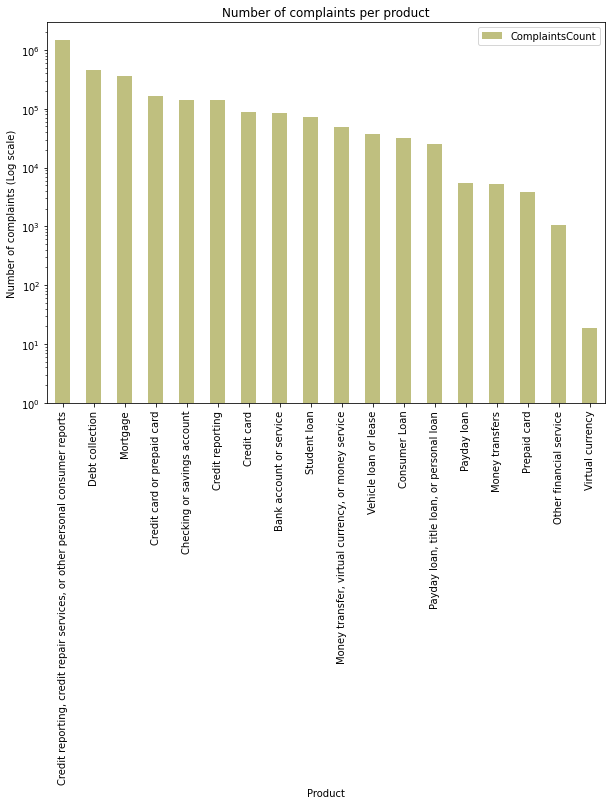

In [37]:
pl = ComplaintsCountPerProduct.toPandas().plot(kind="bar", 
                            x="product", y="ComplaintsCount", 
                            figsize=(10, 7), log=True, alpha=0.5, color="olive")
pl.set_xlabel("Product")
pl.set_ylabel("Number of complaints (Log scale)")
pl.set_title("Number of complaints per product")
plt.show()

In [38]:
print(f'The total number of products in the dataset is {complaints_df.select(countDistinct("product")).collect()[0][0]}')

The total number of products in the dataset is 18


In [39]:
complaints_df.select(countDistinct("company_public_response")).collect()[0][0]

12

In [40]:
company_public_response_count = complaints_df.groupBy("company_public_response")\
                                    .agg(count("*").alias("ComplaintsCount"))\
                                    .sort(desc("ComplaintsCount"))
company_public_response_count.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------+---------------+
|company_public_response                                                                                                |ComplaintsCount|
+-----------------------------------------------------------------------------------------------------------------------+---------------+
|                                                                                                                       |1766304        |
|Company has responded to the consumer and the CFPB and chooses not to provide a public response                        |1153102        |
|Company believes it acted appropriately as authorized by contract or law                                               |112514         |
|Company chooses not to provide a public response                                                                       |52473          |
|Company believes the complaint is

In [93]:
company_response_count = complaints_df.groupBy("company_response")\
                                    .agg(count("*").alias("count"))\
                                    .sort(desc("count"))

company_response_count.show(truncate=False)

+-------------------------------+-------+
|company_response               |count  |
+-------------------------------+-------+
|Closed with explanation        |2417132|
|Closed with non-monetary relief|466957 |
|Closed with monetary relief    |123524 |
|In progress                    |70021  |
|Closed without relief          |17868  |
|Closed                         |17611  |
|Untimely response              |9355   |
|Closed with relief             |5304   |
|                               |4      |
+-------------------------------+-------+



In [41]:
complaints_df.groupBy("submitted_via")\
            .agg(count("*").alias("ComplaintsCount"))\
            .sort(desc("ComplaintsCount")).show(truncate=False)

+-------------+---------------+
|submitted_via|ComplaintsCount|
+-------------+---------------+
|Web          |2629877        |
|Referral     |237492         |
|Phone        |147498         |
|Postal mail  |86341          |
|Fax          |25660          |
|Web Referral |484            |
|Email        |424            |
+-------------+---------------+



In [103]:
complaints_df.select('state').distinct().show()

+--------------------+
|               state|
+--------------------+
|UNITED STATES MIN...|
|                  AZ|
|                  SC|
|                  LA|
|                  MN|
|                  AA|
|                  NJ|
|                  DC|
|                  OR|
|                  VA|
|                  RI|
|                  KY|
|                  WY|
|                  NH|
|                  MI|
|                  NV|
|                  WI|
|                  ID|
|                  CA|
|                  CT|
+--------------------+
only showing top 20 rows



In [105]:
print(f'The total number of state in the dataset is {complaints_df.select(countDistinct("state")).collect()[0][0]}')

The total number of state in the dataset is 64


In [43]:
statewise_complaints_count = complaints_df.groupBy("state")\
                                    .agg(count("*").alias("count"))\
                                    .sort(desc("count"))

statewise_complaints_count.show(truncate=False)

+-----+------+
|state|count |
+-----+------+
|CA   |381389|
|FL   |350313|
|TX   |305289|
|NY   |204477|
|GA   |197188|
|PA   |141286|
|IL   |119176|
|NJ   |107395|
|NC   |98699 |
|OH   |84040 |
|MD   |83916 |
|VA   |79859 |
|MI   |69414 |
|TN   |61064 |
|AL   |57789 |
|AZ   |57321 |
|SC   |54923 |
|LA   |49813 |
|MA   |49303 |
|WA   |44082 |
+-----+------+
only showing top 20 rows



In [46]:
import plotly.express as px
fig = px.choropleth(statewise_complaints_count.toPandas(),
                    locations='state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='count',
                    color_continuous_scale="Viridis_r", 
                   )

fig.update_layout(
      title_text = 'Total Number of complaints by State from 2011 to 2020',
      title_font_family="Times New Roman",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45, 
         )


fig.show()

In [47]:
statewise_complaints_per_year_count = complaints_df.groupBy(["state", year("date_received").alias('year')])\
                                    .agg(count("*").alias("count"))\
                                    .sort("year")

statewise_complaints_per_year_count.show(truncate=False)

+-----+----+-----+
|state|year|count|
+-----+----+-----+
|SC   |2011|21   |
|LA   |2011|12   |
|NE   |2011|4    |
|IA   |2011|13   |
|GA   |2011|99   |
|DC   |2011|11   |
|WA   |2011|64   |
|WI   |2011|24   |
|KS   |2011|15   |
|ND   |2011|1    |
|HI   |2011|13   |
|DE   |2011|15   |
|AK   |2011|5    |
|AR   |2011|9    |
|MA   |2011|71   |
|WV   |2011|7    |
|RI   |2011|10   |
|SD   |2011|10   |
|OH   |2011|69   |
|TN   |2011|37   |
+-----+----+-----+
only showing top 20 rows



In [66]:
df = statewise_complaints_per_year_count.toPandas()
df['year'] = df['year'].astype(str)

fig = px.choropleth(df,
                    locations='state', 
                    locationmode="USA-states", 
                    color='count',
                    color_continuous_scale="Viridis_r", 
                    scope="usa",
                    animation_frame='year') 


fig.update_layout(
      title_text = 'Number of complaints per State over the years 2011 to 2020',
      title_font_family="Times New Roman",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45, 
    )


fig.show()

In [49]:
complaints_df.select('issue').distinct().show()

+--------------------+
|               issue|
+--------------------+
|Communication tac...|
|Application proce...|
|Unexpected or oth...|
|Advertising and m...|
|Problem with an o...|
|Getting a loan or...|
|Balance transfer fee|
|Customer service/...|
|        Adding money|
|Credit card prote...|
|Closing/Cancellin...|
|Received a loan I...|
|Vehicle was repos...|
|Can't stop charge...|
|                Fees|
|          Bankruptcy|
|Forbearance / Wor...|
|Credit determination|
|Confusing or miss...|
|Loan modification...|
+--------------------+
only showing top 20 rows



In [50]:
complaints_df.groupBy("issue")\
            .agg(count("*").alias("ComplaintsCount"))\
            .sort(desc("ComplaintsCount")).show(truncate=False)

+--------------------------------------------------------------------------------+---------------+
|issue                                                                           |ComplaintsCount|
+--------------------------------------------------------------------------------+---------------+
|Incorrect information on your report                                            |767376         |
|Problem with a credit reporting company's investigation into an existing problem|389191         |
|Improper use of your report                                                     |272041         |
|Attempts to collect debt not owed                                               |153580         |
|Loan modification,collection,foreclosure                                        |112309         |
|Incorrect information on credit report                                          |102684         |
|Managing an account                                                             |89005          |
|Loan serv

In [54]:
complaints_df.select('company_response').distinct().show(truncate=False)

+-------------------------------+
|company_response               |
+-------------------------------+
|Untimely response              |
|Closed with non-monetary relief|
|Closed without relief          |
|In progress                    |
|Closed with monetary relief    |
|Closed with explanation        |
|Closed                         |
|Closed with relief             |
|                               |
+-------------------------------+



In [55]:
complaints_df.groupBy("company_response")\
            .agg(count("*").alias("ComplaintsCount"))\
            .sort(desc("ComplaintsCount")).show(truncate=False)

+-------------------------------+---------------+
|company_response               |ComplaintsCount|
+-------------------------------+---------------+
|Closed with explanation        |2417132        |
|Closed with non-monetary relief|466957         |
|Closed with monetary relief    |123524         |
|In progress                    |70021          |
|Closed without relief          |17868          |
|Closed                         |17611          |
|Untimely response              |9355           |
|Closed with relief             |5304           |
|                               |4              |
+-------------------------------+---------------+



In [85]:
complaints_df.groupBy(["company_response", "timely"])\
            .agg(count("*").alias("ComplaintsCount"))\
            .sort(desc("ComplaintsCount")).show(truncate=False)

+-------------------------------+------+---------------+
|company_response               |timely|ComplaintsCount|
+-------------------------------+------+---------------+
|Closed with explanation        |Yes   |2382878        |
|Closed with non-monetary relief|Yes   |464419         |
|Closed with monetary relief    |Yes   |121736         |
|In progress                    |Yes   |70021          |
|Closed with explanation        |No    |34254          |
|Closed without relief          |Yes   |17352          |
|Closed                         |Yes   |15870          |
|Untimely response              |No    |9355           |
|Closed with relief             |Yes   |5121           |
|Closed with non-monetary relief|No    |2538           |
|Closed with monetary relief    |No    |1788           |
|Closed                         |No    |1741           |
|Closed without relief          |No    |516            |
|Closed with relief             |No    |183            |
|                              

In [87]:
complaints_df.filter(complaints_df['company_response'] == 'Untimely response').select('company_public_response').distinct().show()

+-----------------------+
|company_public_response|
+-----------------------+
|                       |
+-----------------------+



All Complaints with Untimely response status has timely column as 'No' Value and has no company_public_response

In [93]:
untimely_response_count_per_state =complaints_df.filter(complaints_df['company_response'] == 'Untimely response') \
            .groupBy("state")\
            .agg(count("*").alias("Untimely_response_count"))\
            .sort(desc("Untimely_response_count"))
untimely_response_count_per_state.show(truncate=False)

+-----+-----------------------+
|state|Untimely_response_count|
+-----+-----------------------+
|CA   |1123                   |
|TX   |926                    |
|FL   |910                    |
|GA   |530                    |
|NY   |404                    |
|PA   |340                    |
|IL   |316                    |
|NJ   |296                    |
|OH   |285                    |
|VA   |275                    |
|WA   |243                    |
|NC   |235                    |
|TN   |220                    |
|     |219                    |
|MD   |208                    |
|MI   |206                    |
|AZ   |178                    |
|SC   |169                    |
|MO   |163                    |
|IN   |146                    |
+-----+-----------------------+
only showing top 20 rows



In [95]:

fig = px.choropleth(untimely_response_count_per_state.toPandas(),
                    locations='state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='Untimely_response_count',
                    color_continuous_scale="Viridis_r", 
                   )

fig.update_layout(
      title_text = 'Total Number of complaints with untimely response in each State from 2011 to 2020',
      title_font_family="Times New Roman",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45, 
         )


fig.show()

In [100]:
complaints_df.filter(complaints_df['company_response'] == 'Untimely response') \
            .groupBy("issue")\
            .agg(count("*").alias("Untimely_response_count"))\
            .sort(desc("Untimely_response_count")).show(truncate=False)

+--------------------------------------------------------------------------------+-----------------------+
|issue                                                                           |Untimely_response_count|
+--------------------------------------------------------------------------------+-----------------------+
|Attempts to collect debt not owed                                               |1048                   |
|Incorrect information on your report                                            |837                    |
|Communication tactics                                                           |825                    |
|Took or threatened to take negative or legal action                             |664                    |
|Cont'd attempts collect debt not owed                                           |598                    |
|False statements or representation                                              |500                    |
|Written notification about debt     

In [104]:
complaints_df.groupBy('tags').agg(count("*").alias("complaints_count")).sort(desc("complaints_count")).show()

+--------------------+----------------+
|                tags|complaints_count|
+--------------------+----------------+
|                    |         2774235|
|       Servicemember|          196522|
|      Older American|          127170|
|Older American, S...|           29849|
+--------------------+----------------+



In [ ]:
spark.stop()